### Setting up GPU memory growth to avoid OOM errors

In [1]:
import tensorflow as tf
%load_ext tensorboard

# avoid oom errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])

### Define Hyperparameter

This hyperparameter is used for Meta Learning and Few-shot Learning task

In [ ]:
learning_rate = .003
meta_step_size = .25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 2

### Data Preparation

The directory structure will look like this
```
dataset/
├── female
└── male
```
Each directory contains approximately 29k. For the few-shot learning task, k samples are drawn randomly from n randomly chosen classes. These n numerical values are used to create a new set of temporary labels to use to test the model ability to learn a new task given few examples.

In [ ]:
class Dataset:
    

In [2]:
import pathlib

base_dir = pathlib.Path('dataset')

In [3]:
n_classes = len(list(base_dir.glob('*')))
image_count = len(list(base_dir.glob('*/*.jpg')))
print('Total image from {} classes: {}'.format(n_classes, image_count))

Total image from 2 classes: 58658


In [4]:
# taking 5 image from each class for sample

female = list(base_dir.glob('female/*'))[:5]
male = list(base_dir.glob('male/*'))[:5]

### Visualize the Sample Data

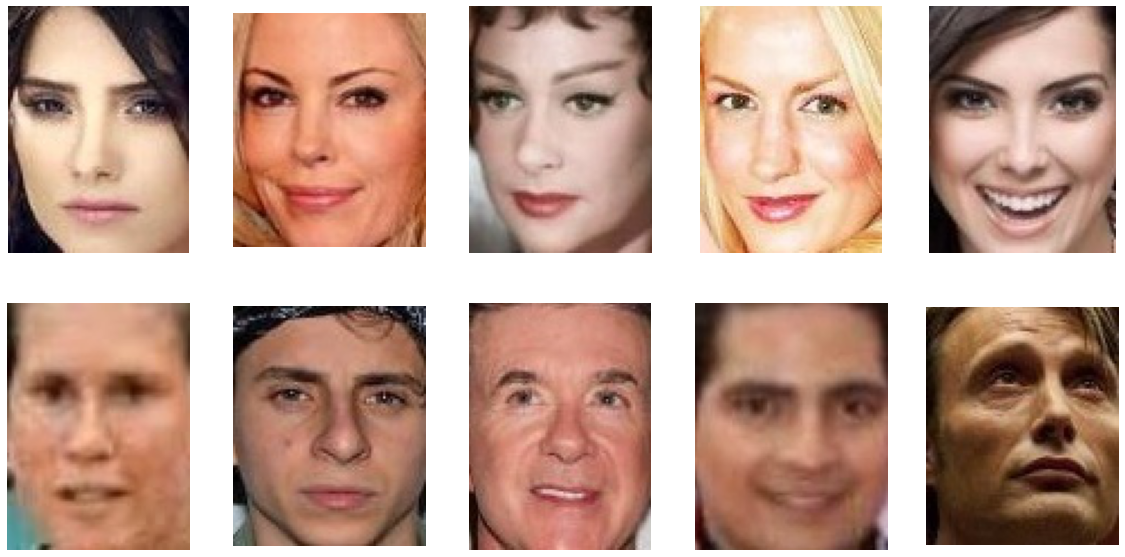

In [5]:
import PIL
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(20,10))
for i in range(5):
    female_img = PIL.Image.open(str(female[i]))
    male_img = PIL.Image.open(str(male[i]))
    
    # plot for female face
    ax[0][i].imshow(female_img)
    ax[0][i].axis('off')
    
    # plot for male face
    ax[1][i].imshow(male_img)
    ax[1][i].axis('off')
plt.show()

### Create Dataset

In [6]:
img_h = 224
img_w = 224
seed = 32
batch_size = 256

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the Load and preprocess images tutorial.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=.1,
    subset='training',
    seed=seed,
    image_size=(img_h, img_w),
    batch_size=batch_size
)

Found 58658 files belonging to 2 classes.
Using 52793 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=.1,
    subset='validation',
    seed=seed,
    image_size=(img_h, img_w),
    batch_size=batch_size
)

Found 58658 files belonging to 2 classes.
Using 5865 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.



In [9]:
class_names = train_ds.class_names
print(class_names)

['female', 'male']


### Visualize the Data

Taking the first nine image from the training dataset

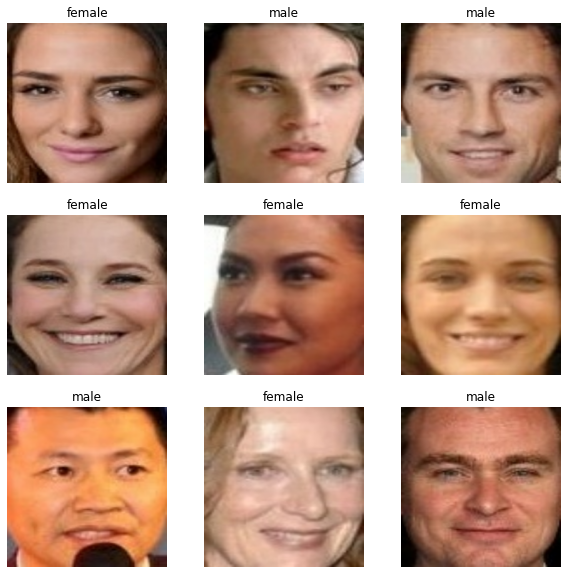

In [10]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
import numpy as np

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print('Max pixel in image:', np.max(first_image))
print('Min pixel in image:', np.min(first_image))
print('Image shape:', first_image.shape)

Max pixel in image: 254.94707
Min pixel in image: 0.0


### Configure Dataset for Performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from datetime import datetime

logdir = 'logs/scalars/' + datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Standardize Data

In [14]:
def standardize(image):
    image = resizing_layer(image)
    image = normalization_layer(image)
    return image

In [15]:
from keras.layers import Resizing, Rescaling

resizing_layer = Resizing(img_h, img_w)
normalization_layer = Rescaling(1./255)

In [16]:
train_ds = train_ds.map(lambda x, y: (standardize(x), y))

In [ ]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print('Max pixel in image:', np.max(first_image))
print('Min pixel in image:', np.min(first_image))
print('Image shape:', first_image.shape)

### Visualize the Normalized Data

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

### Modeling

In [20]:
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [21]:
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

with tf.device('/GPU:0'):
    model = Sequential([
        Input(shape=(img_h, img_w, 3)),
        Resizing(img_h, img_w),
        Rescaling(1./255),
        Conv2D(64, (7,7), padding='same', activation='relu'),
        MaxPooling2D(2,2, padding='same'),
        Conv2D(64, (1,1), padding='same', activation='relu'),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        Conv2D(256, (1,1), padding='same', activation='relu'),
        MaxPooling2D(2,2, padding='same'),
        Conv2D(128, (1,1), padding='same', activation='relu'),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        Conv2D(512, (1,1), padding='same', activation='relu'),
        MaxPooling2D(2,2, padding='same'),
        Conv2D(256, (1,1), padding='same', activation='relu'),
        Conv2D(256, (3,3), padding='same', activation='relu'),
        Conv2D(1024, (1,1), padding='same', activation='relu'),
        MaxPooling2D(2,2, padding='same'),
        Conv2D(512, (1,1), padding='same', activation='relu'),
        Conv2D(512, (3,3), padding='same', activation='relu'),
        Conv2D(2048, (1,1), padding='same', activation='relu'),
        MaxPooling2D(2,2, padding='same'),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(n_classes)
    ])
    
    model.compile(
        optimizer='adam',
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

NameError: name 'Sequential' is not defined

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import Callback

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > .95 and logs.get('val_accuracy') > .95:
            print('\nStopping training. Accuracy has reached 95%')
            self.model.stop_training = True

In [ ]:
from keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=.25, patience=5),
    MyCallback(),
    tensorboard_callback
]

In [ ]:
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=callbacks
)

In [ ]:
%tensorboard --logdir logs/scalars